In [ ]:
!pip install OpenAttack

In [ ]:
!pip install datasets

In [ ]:
import OpenAttack
import torch
import datasets
import tqdm

from OpenAttack.text_process.tokenizer import PunctTokenizer

tokenizer = PunctTokenizer()

class MyClassifier(OpenAttack.Classifier):
    def __init__(self, model, vocab) -> None:
        self.model = model
        self.vocab = vocab
    
    def get_prob(self, sentences):
        with torch.no_grad():
            token_ids = make_batch_tokens([
                tokenizer.tokenize(sent, pos_tagging=False) for sent in sentences
            ], self.vocab)
            token_ids = torch.LongTensor(token_ids)
            return self.model(token_ids).cpu().numpy()
    
    def get_pred(self, sentences):
        return self.get_prob(sentences).argmax(axis=1)


# Design a feedforward neural network as the the victim sentiment analysis model
def make_model(vocab_size):
    
    import torch.nn as nn
    class TextSentiment(nn.Module):
        def __init__(self, vocab_size, embed_dim=32, num_class=2):
            super().__init__()
            self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
            self.fc = nn.Linear(embed_dim, num_class)
            self.softmax = nn.Softmax(dim=1)
            self.init_weights()

        def init_weights(self):
            initrange = 0.5
            self.embedding.weight.data.uniform_(-initrange, initrange)
            self.fc.weight.data.uniform_(-initrange, initrange)
            self.fc.bias.data.zero_()

        def forward(self, text):
            embedded = self.embedding(text, None)
            return self.softmax(self.fc(embedded))
    return TextSentiment(vocab_size)

def dataset_mapping(x):
    return {
        "x": x["sentence"],
        "y": 1 if x["label"] > 0.5 else 0,
        "tokens":  tokenizer.tokenize(x["sentence"], pos_tagging=False)
    }

# Choose SST-2(Stanford Sentiment Treebank (SST)) as the dataset
def prepare_data():
    vocab = {
        "<UNK>": 0,
        "<PAD>": 1
    }
    dataset = datasets.load_dataset("sst").map(function=dataset_mapping).remove_columns(["label", "sentence", "tree"])
    for dataset_name in ["train", "validation", "test"]:
        for inst in dataset[dataset_name]:
            for token in inst["tokens"]:
                if token not in vocab:
                    vocab[token] = len(vocab)
    return dataset["train"], dataset["validation"], dataset["test"], vocab

def make_batch_tokens(tokens_list, vocab):
    batch_x = [
        [ 
            vocab[token] if token in vocab else vocab["<UNK>"]
                for token in tokens
        ] for tokens in tokens_list
    ]
    max_len = max( [len(tokens) for tokens in tokens_list] )
    batch_x = [
        sentence + [vocab["<PAD>"]] * (max_len - len(sentence))
            for sentence in batch_x
    ]
    return batch_x

# Batch data
def make_batch(data, vocab):
    batch_x = make_batch_tokens(data["tokens"], vocab)
    batch_y = data["y"]
    return torch.LongTensor(batch_x), torch.LongTensor(batch_y)

# Train the victim model for one epoch 
def train_epoch(model, dataset, vocab, batch_size=128, learning_rate=5e-3):
    dataset = dataset.shuffle()
    model.train()
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    avg_loss = 0
    for start in range(0, len(dataset), batch_size):
        train_x, train_y = make_batch(dataset[start: start + batch_size], vocab)
        pred = model(train_x)
        loss = criterion(pred.log(), train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    return avg_loss / len(dataset)

def eval_classifier_acc(dataset, victim):
    correct = 0
    for inst in dataset:
        correct += (victim.get_pred( [inst["x"]] )[0] == inst["y"])
    return correct / len(dataset)

# Train the victim model and conduct evaluation
def train_model(model, data_train, data_valid, vocab, num_epoch=10):
    mx_acc = None
    mx_model = None
    for i in range(num_epoch):
        loss = train_epoch(model, data_train, vocab)
        victim = MyClassifier(model, vocab)
        accuracy = eval_classifier_acc(data_valid, victim)
        print("Epoch %d: loss: %lf, accuracy %lf" % (i, loss, accuracy))
        if mx_acc is None or mx_acc < accuracy:
            mx_model = model.state_dict()
    model.load_state_dict(mx_model)
    return model

# Launch adversarial attacks and generate adversarial examples 
def attack(classifier, dataset, attacker = OpenAttack.attackers.PWWSAttacker()):
    attack_eval = OpenAttack.AttackEval(
        attacker,
        classifier,
    )
    correct_samples = [
        inst for inst in dataset if classifier.get_pred( [inst["x"]] )[0] == inst["y"]
    ]
    
    accuracy = len(correct_samples) / len(dataset)

    adversarial_samples = {
        "x": [],
        "y": [],
        "tokens": []
    }
    
    for result in tqdm.tqdm(attack_eval.ieval(correct_samples), total=len(correct_samples)):
        if result["success"]:
            adversarial_samples["x"].append(result["result"])
            adversarial_samples["y"].append(result["data"]["y"])
            adversarial_samples["tokens"].append(tokenizer.tokenize(result["result"], pos_tagging=False))
    
    attack_success_rate = len(adversarial_samples["x"]) / len(correct_samples)

    print("Accuracy: %lf%%\nAttack success rate: %lf%%" % (accuracy * 100, attack_success_rate * 100))

    return datasets.Dataset.from_dict(adversarial_samples)

def main():
    print("Loading data")
    train, valid, test, vocab = prepare_data() # Load dataset
    model = make_model(len(vocab)) # Design a victim model

    print("Training")
    trained_model = train_model(model, train, valid, vocab) # Train the victim model
    
    print("Generating adversarial samples (this step will take dozens of minutes)")
    victim = MyClassifier(trained_model, vocab) # Wrap the victim model
    adversarial_samples = attack(victim, train) # Conduct adversarial attacks and generate adversarial examples

    print("Adversarially training classifier")
    print(train.features)
    print(adversarial_samples.features)

    new_dataset = {
        "x": [],
        "y": [],
        "tokens": []
    }
    for it in train:
        new_dataset["x"].append( it["x"] )
        new_dataset["y"].append( it["y"] )
        new_dataset["tokens"].append( it["tokens"] )
    
    for it in adversarial_samples:
        new_dataset["x"].append( it["x"] )
        new_dataset["y"].append( it["y"] )
        new_dataset["tokens"].append( it["tokens"] )
        
    finetune_model = train_model(trained_model, datasets.Dataset.from_dict(new_dataset), valid, vocab) # Retrain the classifier with additional adversarial examples

    print("Testing enhanced model (this step will take dozens of minutes)")
    attack(victim, train) # Re-attack the victim model to measure the effect of adversarial training

if __name__ == '__main__':
    main()

/usr/local/lib/python3.10/dist-packages/nltk/corpus/reader/wordnet.py:1183: UserWarning: The multilingual functions are not available with this Wordnet version
  warnings.warn(


Loading data


Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

Dataset sst downloaded and prepared to /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/8544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1101 [00:00<?, ? examples/s]

Map:   0%|          | 0/2210 [00:00<?, ? examples/s]

Training
Epoch 0: loss: 0.005330, accuracy 0.697548
Epoch 1: loss: 0.004823, accuracy 0.726612
Epoch 2: loss: 0.004138, accuracy 0.732062
Epoch 3: loss: 0.003456, accuracy 0.737511
Epoch 4: loss: 0.002903, accuracy 0.731153
Epoch 5: loss: 0.002444, accuracy 0.730245
Epoch 6: loss: 0.002072, accuracy 0.736603
Epoch 7: loss: 0.001763, accuracy 0.730245
Epoch 8: loss: 0.001547, accuracy 0.728429
Epoch 9: loss: 0.001319, accuracy 0.733878
Generating adversarial samples (this step will take dozens of minutes)


100%|██████████| 8213/8213 [01:47<00:00, 76.49it/s] 


Accuracy: 96.125936%
Attack success rate: 90.831608%
Adversarially training classifier
{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'x': Value(dtype='string', id=None), 'y': Value(dtype='int64', id=None)}
{'x': Value(dtype='string', id=None), 'y': Value(dtype='int64', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}
Epoch 0: loss: 0.004106, accuracy 0.734787
Epoch 1: loss: 0.002764, accuracy 0.731153
Epoch 2: loss: 0.001939, accuracy 0.727520
Epoch 3: loss: 0.001508, accuracy 0.720254
Epoch 4: loss: 0.001243, accuracy 0.719346
Epoch 5: loss: 0.001053, accuracy 0.712988
Epoch 6: loss: 0.000931, accuracy 0.706630
Epoch 7: loss: 0.000818, accuracy 0.701181
Epoch 8: loss: 0.000711, accuracy 0.701181
Epoch 9: loss: 0.000651, accuracy 0.698456
Testing enhanced model (this step will take dozens of minutes)


100%|██████████| 8339/8339 [01:44<00:00, 79.60it/s] 


Accuracy: 97.600655%
Attack success rate: 81.208778%


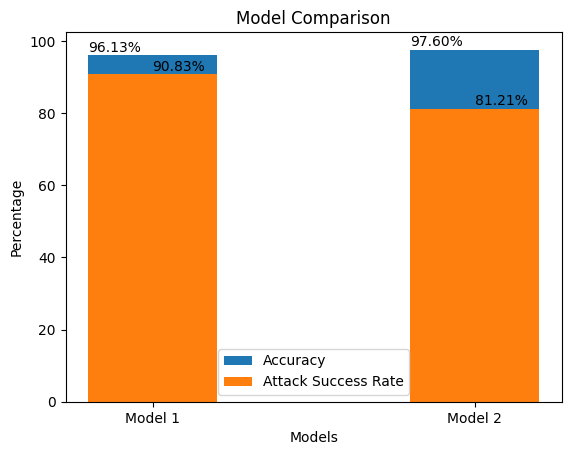

In [1]:
import matplotlib.pyplot as plt

# Model accuracy and attack success rate values
accuracy = [96.125936, 97.600655]
attack_success_rate = [90.831608, 81.208778]

# Create a bar plot
models = ['Model 1', 'Model 2']
x = range(len(models))

plt.bar(x, accuracy, width=0.4, label='Accuracy')
plt.bar(x, attack_success_rate, width=0.4, label='Attack Success Rate')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Percentage')
plt.title('Model Comparison')

# Add legend
plt.legend()

# Add values above the bars
for i, v in enumerate(accuracy):
    plt.text(i - 0.2, v + 1, f"{v:.2f}%", color='black')
    
for i, v in enumerate(attack_success_rate):
    plt.text(i, v + 1, f"{v:.2f}%", color='black')

# Customize the x-axis tick labels
plt.xticks(x, models)

# Display the plot
plt.show()
